## 4. Multilayer Perceptrons

In [1]:
%matplotlib inline
# import matplotlib.pyplot as plt

import d2l
from mxnet import autograd, np, npx

npx.set_np()

#### 4.1.2 Activation Functions

Activation functions decide whether a neuron should be activated or not by calculating the weighted sum and further adding bias to it. They are differentiable operators to transform input signals to outputs, while most of them add non-linearity. Because activation functions are fundamental to deep learning, let's briefly survey some common activation functions.

##### ReLU Function

As stated before, the most popular choice, due to both simplicity of implementation, and its performance on a variety of predictive tasks, is the ReLU activation function. ReLU provides a very simple nonlinear transformation. Given the element $z$, the function is defined as the maximum of that element and 0.

- ReLU$(z) = max(z, 0)$

Informally, the ReLU function retains only positive elements and discards all negative elements (setting the corresponding activations to 0). To gain some intuition, we can plot the function. Because it is used so commonly, NDarray supports the relu function as a native operator. As you can see, the activation function is **piecewise linear**.

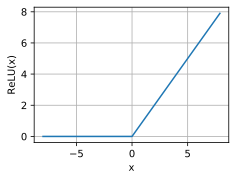

In [2]:
x = np.arange(-8.0, 8.0, 0.1)
x.attach_grad()


with autograd.record():
    y = npx.relu(x)
d2l.set_figsize((4,2.5))
d2l.plot(x, y, 'x', 'ReLU(x)')

When the input is negative, the derivative of ReLU function is 0 and when the input is positive, the derivative of ReLU is 1. **Note that the ReLU function is not differentiable when the input takes value precisely equal to 0. In these cases, we default to the left-hand-side (LHS) derivative and say that the derivative is 0 when the input is 0.** We can get away with this because the input may never actually be 0. There is an old adage saying that if subtle boundary conditions matter, we are probably doing (*real*) mathematics, not engineering. That conventional wisdom may apply here. Below there is a plot of the derivative of the ReLU function.

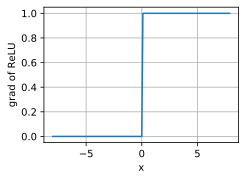

In [3]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of ReLU')

#### Sigmoid Function

The sigmoid function transforms its inputs, which values in the domain $\mathbb R$ , to outputs that lie in the interval $(0,1)$. For that reason, the sigmoid is often called a *squashing* function: it squashes any input in the range (-inf, inf) to some value in the range (0,1).

$sigmoid(x) = \frac{1}{1+exp(-x)}$

In the earliest neural networks, scientists were interested in modeling biological neurons which either fire or do not fire. Thus the pioneers of this field, going all the way back to McCulloch and Pitts, the inventors of artificial neuron, focused on thresholding units. A thresholding activation takes value 0 when its input is below some threshold and value 1 when the input exceeds the threshold.

When attention shifted to **gradient based learning**, the sigmoid function was a natural choice, because it is a smooth, differentiable approximation to a thresholding unit. Sigmoids are still widely used as activation functions on the output units, when we want to interpret the outputs as probabilities for binary classification problems (you can think of the sigmoid as a special case of the softmax). However, the sigmoid has mostly been replaced by the simpler and more easily trainable ReLU for most use in hidden layers.

The derivative of sigmoid function is given by the following equation:

$\frac{d}{dx}sigmoid(x)=\frac{exp(-x)}{(1 + exp(-x))^2}=sigmoid(x)(1-sigmoid(x))$

In [4]:
x = np.arange(-8,8,0.1)
x.attach_grad()

In [5]:
with autograd.record():
    y = npx.sigmoid(x)
y.backward()

Note that when the input is close to 0, the sigmoid function approaches a linear transformation.

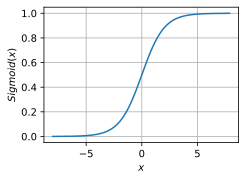

In [6]:
d2l.plot(x, npx.sigmoid(x), xlabel = '$x$', ylabel = '$Sigmoid(x)$')

The derivative of a sigmoid function is plotted below. Note that when the input is 0, the derivative of the sigmoid function reaches a **maximum of 0.25**. As the input diverges from 0 in either direction, the derivative approaches 0.

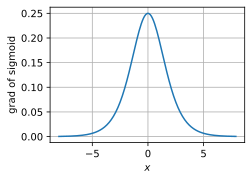

In [7]:
d2l.plot(x, x.grad, xlabel = '$x$', ylabel = 'grad of sigmoid')

#### Tanh Function

Like the sigmoid function, the tanh (Hyperbolic Tangent) function also squashes its inputs, transforms them into elements on the interval between -1 and 1:

$tanh(x) = \frac{1 - exp(-2x)}{1 + exp(-2x)}$

Note that as the input nears 0, the tanh function **approaches a linear transformation**. Although the shape of the function is similar to the sigmoid function, the tanh function exhibits **point symmetry about the origin of the coordinate system**.

In [8]:
x = np.arange(-8,8,0.1)
x.attach_grad()

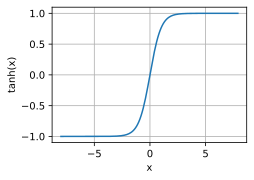

In [9]:
with autograd.record():
    y = np.tanh(x)
d2l.plot(x,y, 'x', 'tanh(x)')

In [10]:
y.backward()

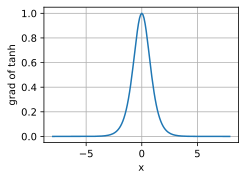

In [11]:
d2l.plot(x, x.grad, 'x', 'grad of tanh')

## 4.2 Implementation of Multilayer Perceptron from Scratch

Now that we have characterized MLPs mathematically, let's try to implement one ourselves

In [1]:
import d2l
from mxnet import gluon, np, npx

npx.set_np()

To compare against our previous results achieved with (linear) softmax regression, we will continue work with the Fashion-MNIST image classification dataset.

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

#### 4.2.1 Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes, and that each image consist of 28 x 28 = 784 grid of (black and white) pixel values. Again, we will disregard the spatial structure among the pixels (for now), so we can think of this as simply a classification dataset with 784 input features and 10 classes. To begin, we will implement an MLP with one hidden layer and 256 hidden units. Note that we can regard both of these quantities as *hyperparameters* and ought in general to set them based on performance on validation data. **Typically, we choose layer widths in powers of 2 which tends to be computationally efficient because of how memory is alotted and adressed in the hardware.**

Again, we will represent our parameters with several ndarrays. Note that *for every layer*, we must keep track of one weight matrix and one bias vector. As always, we call `attach_grad()` to allocate memory for the gradients (of the loss) with respect to these parameters.

In [14]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = np.random.normal(scale = 0.01, size = (num_inputs, num_hiddens))
b1 = np.zeros(num_hiddens)
W2 = np.random.normal(scale = 0.01, size = (num_hiddens, num_outputs))
b2 = np.zeros(num_outputs)

parameters = [W1, b1, W2, b2]

for param in parameters:
    param.attach_grad()

#### 4.2.2 Activation Function

To make sure we know how everything works, we will implement the ReLU activation function ourselves using the maximum function rather than invoking `npx.relu` directly.

In [15]:
def relu(X):
    return np.maximum(X, 0)

#### 4.2.3 The Model

Because we are disregarding the spatial structure (for now), we `reshape` each 2D image into a flat vector of length `num_inputs`. Finally, we implement our model with just a few lines of code.

In [16]:
def net(X):
    X = X.reshape(-1, num_inputs)
    H = relu(np.dot(X, W1) + b1)
    return np.dot(H, W2) + b2

#### 4.2.4 The Loss Function

To ensure numerical stability (and because we already implemented the softmax function from scratch), we leverage Gluon's integrated function for calculating the softmax and cross-entropy loss.

In [17]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

#### 4.2.5 Training

Fortunately, the training loop for MLPs is exactly the same as for softmax regression. Leveraging the d2l package again, we call the train_ch3 function.

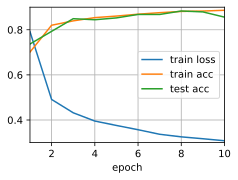

In [18]:
num_epochs = 10
lr = 0.5

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(parameters, lr, batch_size))

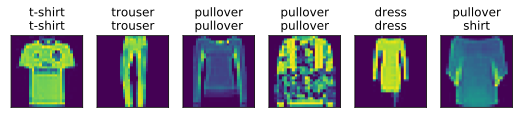

In [19]:
d2l.predict_ch3(net, test_iter)

In [20]:
d2l.evaluate_accuracy(net, test_iter)

0.856

#### Exercises

1) Change the value of the hyperparameter `num hiddens` and see how this hyperparameter influences your results. Determine the best value of this hyperparameter, keeping all others constant.

In [21]:
num_inputs, num_outputs, num_hiddens = 784, 10, 512

In [22]:
W1 = np.random.normal(scale = 0.01, size = (num_inputs, num_hiddens))
b1 = np.zeros(num_hiddens)
W2 = np.random.normal(scale = 0.01, size = (num_hiddens, num_outputs))
b2 = np.zeros(num_outputs)

parameters = [W1, b1, W2, b2]

for param in parameters:
    param.attach_grad()

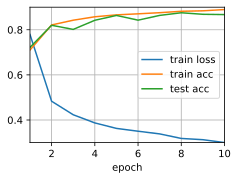

In [23]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(parameters, lr, batch_size))

In [24]:
d2l.evaluate_accuracy(net, test_iter)

0.8673

2) Try adding an additional hidden layer to see how it affects results

In [25]:
num_inputs, num_outputs, hidden_layer_1, hidden_layer_2 = 784, 10, 512, 256

In [26]:
W1 = np.random.normal(scale = 0.01, size = (num_inputs, hidden_layer_1))
b1 = np.zeros(hidden_layer_1)
W2 = np.random.normal(scale = 0.01, size = (hidden_layer_1, hidden_layer_2))
b2 = np.zeros(hidden_layer_2)
W3 = np.random.normal(scale = 0.01, size = (hidden_layer_2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()

In [27]:
def net_2(X):
    X = X.reshape(-1, num_inputs)
    H1 = relu(np.dot(X, W1) + b1)
    H2 = relu(np.dot(H1, W2) + b2)
    return np.dot(H2, W3) + b3

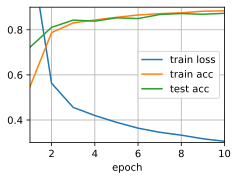

In [28]:
d2l.train_ch3(net_2, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(params, lr, batch_size))

In [29]:
d2l.evaluate_accuracy(net_2, test_iter)

0.873

3) How does changing the learning rate alter your results? Fixing the model architecture and other hyperparameters, what learning rate gives you the best results?

In [30]:
lr = 0.7

In [31]:
num_inputs, num_outputs, hidden_layer_1, hidden_layer_2 = 784, 10, 512, 256

In [32]:
W1 = np.random.normal(scale = 0.01, size = (num_inputs, hidden_layer_1))
b1 = np.zeros(hidden_layer_1)
W2 = np.random.normal(scale = 0.01, size = (hidden_layer_1, hidden_layer_2))
b2 = np.zeros(hidden_layer_2)
W3 = np.random.normal(scale = 0.01, size = (hidden_layer_2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()

In [33]:
def net_2(X):
    X = X.reshape(-1, num_inputs)
    H1 = relu(np.dot(X, W1) + b1)
    H2 = relu(np.dot(H1, W2) + b2)
    return np.dot(H2, W3) + b3

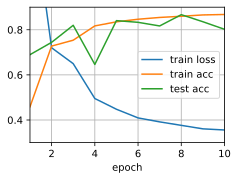

In [34]:
d2l.train_ch3(net_2, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(params, lr, batch_size))

In [35]:
d2l.evaluate_accuracy(net_2, test_iter)

0.8021

4) What is the best result you can get by optimizing over all the parameters (learning rate, iterations, number of hidden layers, number of hidden units per layer) jointly?

In [36]:
num_epochs = 15
lr = 0.3

num_inputs, num_outputs, hidden_layer_1, hidden_layer_2, hidden_layer_3 = 784, 10, 512, 256, 128

In [37]:
W1 = np.random.normal(scale = 0.01, size = (num_inputs, hidden_layer_1))
b1 = np.zeros(hidden_layer_1)
W2 = np.random.normal(scale = 0.01, size = (hidden_layer_1, hidden_layer_2))
b2 = np.zeros(hidden_layer_2)
W3 = np.random.normal(scale = 0.01, size = (hidden_layer_2, hidden_layer_3))
b3 = np.zeros(hidden_layer_3)
W4 = np.random.normal(scale = 0.01, size = (hidden_layer_3, num_outputs))
b4 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3, W4, b4]

for param in params:
    param.attach_grad()

In [38]:
def net_3_lay(X):
    X = X.reshape(-1, num_inputs)
    H1 = relu(np.dot(X, W1) + b1)
    H2 = relu(np.dot(H1, W2) + b2)
    H3 = relu(np.dot(H2, W3) + b3)
    return np.dot(H3, W4) + b4

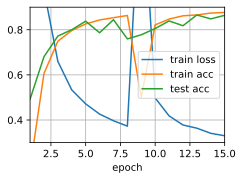

In [39]:
d2l.train_ch3(net_3_lay, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(params, lr, batch_size))

In [40]:
d2l.evaluate_accuracy(net_3_lay, test_iter)

0.8639

## 4.3 Concise Implementation of Multilayer Perceptron

As you might expect, by relying on the Gluon library, we can implement MLPs even more concisely.

In [41]:
import d2l
from mxnet import gluon, init, npx
from mxnet.gluon import nn

npx.set_np()

#### 4.3.1 The Model

As compared to our gluon implementation of softmax regression, the only difference is that we add two Dense (fully-connected) layers (previously, we added one). The first is our hidden layer, which contains 256 hidden units and applies the ReLU activation function. The second is our output layer.

In [42]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'),
       nn.Dense(10))
net.initialize(init.Normal(sigma = 0.01))

Note that Gluon, as usual, **automatically infers the missing input dimensions to each layer**.

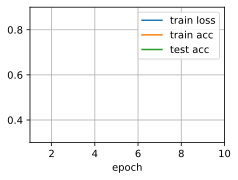

In [ ]:
batch_size, num_epochs = 256, 10

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
d2l.evaluate_accuracy(net, test_iter)

More layers

In [ ]:
net = nn.Sequential()
net.add(nn.Dense(256, activation = 'relu'),
        nn.Dense(128, activation = 'tanh'),
        nn.Dense(10))
net.initialize(init.Normal(sigma = 0.01))

In [ ]:
batch_size, num_epochs = 256, 10

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.5})

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
d2l.evaluate_accuracy(net, test_iter)

# Model Selection, Underfitting and Overfitting

#### 4.4.4 Polynomial Regression

In [1]:
import d2l
from mxnet import gluon, np, npx
from mxnet.gluon import nn

npx.set_np()

#### Generating the dataset

First we need data. Given $x$, we will use the following cubic polynomial to generate the labels on training and test data:

$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6\frac{x^3}{3!} + \epsilon$

The noise term $\epsilon$ obeys a normal distribution with a mean 0 and a standard deviation of 0.1. We will synthesize 100 samples each for the training and test set.

In [2]:
np.power(3, np.array([2,3]).reshape(-1,1))

array([[ 9.],
       [27.]])

In [3]:
maxdegree = 20
n_train, n_test = 100, 100
true_w = np.zeros(maxdegree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1))
features = np.random.shuffle(features)

poly_features = np.power(features, np.arange(maxdegree).reshape(1,-1))
poly_features = poly_features / (
            npx.gamma(np.arange(maxdegree) + 1).reshape(1, -1))
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale = 0.1, size = labels.shape)

In [4]:
features[:2], poly_features[:2], labels[:2]

(array([[0.35655284],
        [0.49383944]]),
 array([[1.0000000e+00, 3.5655284e-01, 6.3564964e-02, 7.5547560e-03,
         6.7341747e-04, 4.8021779e-05, 2.8537170e-06, 1.4535726e-07,
         6.4784436e-09, 2.5665639e-10, 9.1511555e-12, 2.9662460e-13,
         8.8135286e-15, 2.4172992e-16, 6.1563914e-18, 1.4633859e-19,
         3.2610899e-21, 6.8397118e-23, 1.3548437e-24, 2.5424911e-26],
        [1.0000000e+00, 4.9383944e-01, 1.2193870e-01, 2.0072712e-02,
         2.4781744e-03, 2.4476406e-04, 2.0145690e-05, 1.4212480e-06,
         8.7733547e-08, 4.8140314e-09, 2.3773586e-10, 1.0673032e-11,
         4.3923033e-13, 1.6685328e-14, 5.8856238e-16, 1.9377020e-17,
         5.9807102e-19, 1.7373594e-20, 4.7665364e-22, 1.2388966e-23]]),
 array([5.3610864, 5.127728 ]))

#### Training and Testing Model
Let's first implement a function to evaluate the loss on a given data.

In [5]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        metric.add(loss(net(X), y).sum(), y.size)
    return metric[0] / metric[1]

Now define the training function.

In [6]:
def train(train_features, test_features, train_labels, test_labels,
         num_epochs = 1000):
    
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias, since we alreade catered for it in the polynomial features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                              is_train = False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss', yscale = 'log',
                           xlim = [1, num_epochs], ylim = [1e-3, 1e2],
                           legend = ['train', 'test'])
    
    for epoch in range(1, num_epochs + 1):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch % 50 == 0:
            animator.add(epoch, (evaluate_loss(net, train_iter, loss),
                                 evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

#### Third-Order Polynomial Function Fitting (Normal)

We will begin by first using a third-order polynomial function with the same order as the data generation function. The results show that this model's training error rate when using the testing dataset is low. The trained model parameters are also close to the true values $w = [5, 1.2, -3.4, 5.6]$

weight: [[ 4.9841924  1.1654385 -3.3960345  5.6542926]]


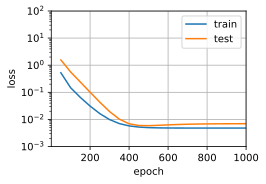

In [7]:
train(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4],
     labels[:n_train], labels[n_train:])

#### Linear Function Fitting (Underfitting)

Let's take a look at linear function fitting. After the decline in the early epoch, it becomes difficult to further decrease this model's training error rate. After the last epoch iteration has been completed, the training error rate is still high. When used to fit non-linear patterns (like the third-order polynomial function here) linear models are liable to underfitting.

weight: [[ 5.1723046  3.9677837 -3.5454192]]


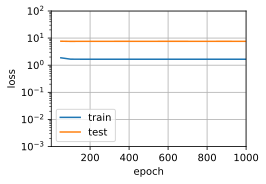

In [8]:
train(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3],
     labels[:n_train], labels[n_train:])

#### Insufficient Training (Overfitting)

Now let's try to train the model using a polynomial of too high degree. Here, there is insufficient data to learn that higher-degree coefficients should have values closer to zero. As a result, our overly-complex model is far to susceptible to being influenced by the noise in the training data. Of course, our training error will now be low (even lower than if we had the right model!) but our test error will be high.

weight: [[ 4.9191113e+00  1.2713025e+00 -3.1398270e+00  5.1774650e+00
  -6.2012374e-01  1.3257469e+00  1.7406296e-02  1.1006608e-01
  -5.2170018e-03 -5.0133109e-02 -2.4056878e-02 -5.7303727e-02
  -3.7403140e-02 -3.6777101e-02  1.6024526e-02  4.7532320e-02
  -6.5369561e-02  3.1318816e-03 -6.7815147e-02  1.8304810e-03]]


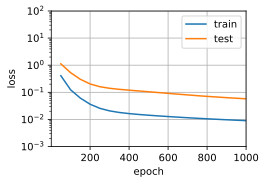

In [9]:
n_subset = 100
n_degree = 20

train(poly_features[1:n_subset, 0:n_degree],
     poly_features[n_train:, 0:n_degree], labels[1:n_subset],
     labels[n_train:])

### 4.5 Weight Decay

Now that we have characterized the problem of overfitting, we can introduce some standard techniques for regularizing models. Recall that we can always mitigate overfitting by going out and collecting more training data, that can be costly, time consuming, or entirely out of our control, making it impossible in the short run. For now, we can assume that we already have as much high-quality data as our resources permit and focus on regularization techniques.

#### 4.5.1 Squared Norm Regularization

*Weight decay* (commonly called L2 regularization), might be the most widely-used technique for regularizing parametric machine learning models. The technique is motivated by the basic intuition that **among all functions $f$, the function $f = 0$ (assigining the value 0 to all its inputs) is in some sense the simplest and that we can measure the complexity of a function by its distance from zero.** But how precisely should we measure the distance between a function and zero? There is no single right answer. In fact, entire branches of mathematics, including parts of functional analysis and the theory of Banach spaces are devoted to answering this issue.

One simple interpretation might be to **measure the complexity of a linear function** $f(\textbf{x}) = \textbf{w}^T\textbf{x}$ by some norm of its weight vector, e.g., $||\textbf{w}||^2$. The most common method for ensuring a small weight vector is to add its norm as a penalty term to the problem of minimizing the loss. Thus we replace our original objective, *minimize the prediction loss on the training labels*, with new objective *minimize the sum of the prediction loss and the penalty term*. Now, if our weight vector grows too large, our learning algorithm might focus on minimizing the wight norm $||\textbf{w}||^2$ versus minimizing the training error. That is exactly what we want. To illustrate things in code, let's review our previous example for linear regression. There, our loss was given by:

- $l(\textbf{w}, b) = \frac{1}{n}\sum\frac{1}{2}(\textbf{w}^T\textbf{x}^{(i)} + b - y^{(i)})^2$

Recall that $\textbf{x}^{(i)}$ are the observations, $y^{(i)}$ are the labels, and $(\textbf{w}, b)$ are the weight and bias parameters respectively. **To penalize the size of the weight vector, we must somehow add $||\textbf{w}||^2$ to the loss function, but how should the model trade off the standard loss for this new additive penalty?** In practice, we characterize this tradeoff via the *regularization constant* $\lambda$ > 0, a non-negative hyperparameter that we fit using validation data:

- $l(\textbf{w}, b) + \frac{\lambda}{2}||\textbf{w}||^2$


For $\lambda = 0$, we recover our original loss function. For $\lambda > 0$, we restrict the size of $||\textbf{w}||$. The astute reader might wonder why we work with the squared norm and not the standard norm (i.e. Euclidean distance). We do this for computational convenience. By squaring the L2 norm, we remove the square root, leaving the sum of squares of each component of the weight vector. This makes the derivative of the penalty easy to compute (the sum of the derivatives equals the derivative of the sum).

Moreover, you might ask why we work with the L2 norm in the first place and not, say, the L1 norm.

In fact, other choices are valid and popular throughout statistics. while L2-regularized linear models constitute the classic *ridge regression* algorithm, L1-regularized linear regression is a similarly fundamental model in statistics (known as *lasso regresion*)

More generally, the $l_2$ is just one among an infinite class of norms called p-norms, many of which you might encounter in the future.

One reason to work with the L2 norm is that it places and outsize **penalty on large components of the weight vector**. This biases our learning algorithm towards models that distribute weight evenly across a larger number of features. In practice, this might make them more robust to measurement error in a single variable. By contrast, L1 penalties lead to models that concentrate weight on a small set of features, which may be desirable for other reasons.

#### 4.5.2 High-Dimensional Linear Regression

We can demonstrate the benefits of weight decay over feature selection through a simple synthetic example. First, let's generate some data:

- $y = 0.05 + \sum{0.01x_i} + \epsilon$

choosing our label to be a linear function of our inputs, corrupted by Gaussian noise with zero mean and variance 0.01. To make the effectsd of overfitting pronounced, we can increase the dimensionality of our problem to d = 200 and work with a small training set containing only 20 examples. 

In [10]:
%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()

In [11]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 1
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train = False)

#### 4.5.3 Implementation from Scratch

Next, we will implement weight decay from scratch, simply by adding the squared l2 penalty to the original target function.

#### Initializing Model Parameters

First, we will define a function to randomly initialize our model parameters and run `attach_grad` on each to allocate memory for the gradients we will calculate.

In [12]:
def init_params():
    w = np.random.normal(scale = 1, size = (num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    
    return [w,b]

#### Defining the $l_2$ Norm Penalty

Perhaps the most convenient way to implement this penalty is to square all terms in place and sum them up. We divide by 2 by convention, (when we take the derivative of a quadratic function, the 2 and $\frac{1}{2}$ cancel out, ensuring that the expression for the update looks nice and simple)

In [13]:
def l2_penalty(w):
    return (w**2).sum() / 2

#### Defining the Train and Test Functions

The following code fits a model on the training set and evaluates it on the test set. The linear network and the squared loss have not changed since the previous implementations, so we will just import them via `d2l.linreg` and `d2l.squared_loss`. The only change here is that our loss now includes the penalty term.

In [14]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss # Great line of code!
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel = 'Epochs', ylabel = 'Loss', yscale = 'log',
                           xlim = [1, num_epochs], legend = ['train', 'test'])
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w,b], lr, batch_size)
        if epoch % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('l1 norm of w:', np.abs(w).sum())

#### Training without Regularization

We now run this code with lambda = 0, disabling weight decay. Note that we overfit badly, decreasing the training error but not the test error - a textbook case of overfitting.

l1 norm of w: 153.39403


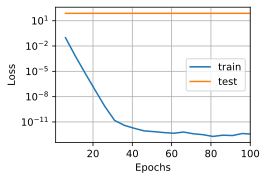

In [15]:
train(lambd=0)

#### Using Weight Decay

Below, we run with substantial weight decay Note that the training error increases but the test error decreases. This is precisely the effect we expect from regularization. As an exercise, you might want to check that the $l_2$ norm of the weights **w** has actually decreased.

l1 norm of w: 0.5993695


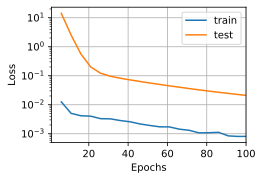

In [16]:
train(lambd=3)

#### 4.5.4 Concise Implementation

Because weight decay is ubiquitous in neural network optimization, Gluon makes it especially convenient, integrating weight decay into the optimization algorithm itself for easy use in combination with any loss function. Moreover, this integration serves a computational benefit, allowing implementation tricks to add weight decay to the algorithm, without any additional computational overhead. Since the weight decay portion of the update depends only on the current value of each parameter, the optimizer must "touch" each parameter once anyway.

In the following code, we specify the weight decay hyperparameter directly through `wd` when instantiating our `Trainer`. **By default, Gluon decays both weights and biases simultaneously**. Note, that the hyperparameter `wd` will be multiplied by `wd_mult` when updating model parameters. Thus, if we set `wd_mult` to 0, the bias parameter `b` will not decay.

In [17]:
def train_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma = 1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                           {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    net.collect_params('.*bias').setattr('wd_mult', 0)
    
    animator = d2l.Animator(xlabel = 'Epochs', ylabel = 'Loss', 
                            yscale = 'log', xlim = [1, num_epochs], 
                            legend = ['train','test'])
    
    for epoch in range(1, num_epochs + 1):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        if epoch % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('L1 norm of w:', np.abs(net[0].weight.data()).sum())

L1 norm of w: 138.86162


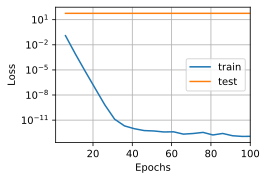

In [18]:
train_gluon(0)

L1 norm of w: 0.41422093


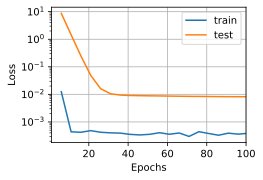

In [19]:
train_gluon(3)

So far, we only touched upon one notion of what constitutes a simple *linear* function. Moreover, what constitutes a simple *nonlinear* function, can be even more complex question. For instance, **Reproducing Kernel Hilbert Spaces (RKHS)** allows one to apply tools introduced for linear functions in nonlinear context. Unfortunately, RKHS-based algorithms tend to scale purely to large, high-dimensional data. In this book we will default to a simple heuristic of applying weight decay on all layers of a deep network.

#### Recap

To sum it all up, the regularization methods (weight decay) are common methods for dealing with overfitting. They add a penalty term to the loss function on the training set to reduce the complexity of the learned model.

## 4.6 Dropout

Just now, in the previous section, we introduced the classical approach to regularizing statistical models by penalizing the $l_2$ norm of the weights. In probabilistic terms, we could justify this technique by arguing that we have **assumed a prior belief that weights take values from a Gaussian distribution with mean 0**. More intuitively, we might argue that we encouraged the model to spread out its weights among many features, rather than depending too much on a small number of potentially spurious associations.

#### 4.6.1 Overfitting Revisited

Faced with more features than examples, linear models tend to overfit. But given more examples **than** features, we can generally count on linear models not to overfit. Unfortunately, the reliability with which linear models generalize comes at a cost:

- Naively applied, linear models do not take into account **interactions** among features

For every feature, a linear model must assign either a positive or negative weight, ignoring context.

In traditional texts, this fundamental tension between generalizability and flexibility is described as the *bias-variance tradeoff*. Linear models have high bias (they can only represent a small class of functions), but low variance (**they give similar results across different random samples of the data**).

Deep neural networks inhabit the opposite end of the bias-variance spectrum. Unlike linear models, neural networks are not confined to looking at each feature individually. They can learn interactions among groups of features. For example ,they might inger that "Nigeria" and "Western Union" appearing together in an email indicates spam but that separately they do not.

Even when we have far more examples than features, DNN are capable of overfitting. In 2017, a group of researchers demonstrated the extreme flexibility of neural networks by training DNN's on randomly-labeled images. Despite the absence of any true pattern linking the inputs to the outputs, they found that the neural network optimized by SGD, could label every image in the training set perfectly.

Consider what this means. If the labels are assigned uniformly at random and there are 10 classes, then no classifier can do better than 10% accuracy on holdout data. The generalization gap here is a whopping 90%. If our models are so expressive that they can overfit this badly, then when should we expect them not to overfit?

#### 4.6.2 Robustness through Perturbations

Let's briefly think what we expect from a good predictive model. We want it to perform well on unseen data. Classical generalization theory suggests that to close the gap between train and test performance, we should aim for the *simple* model. Simplicity can come in the form of a small number of dimensions, as we explored previously. Or, as we saw when discussing weight decay, the inverse norm of the parameters represents another useful measure of simplicity. Another useful notion of simplicity is smoothness, i.e., that the function should not be sensitive to small changes to its inputs. For instance, when we classify images, we would expect that adding some random noise to the pixels should mostly be harmless.

In 1995, Christopher Bishop formalized this idea when he proved that training with input noise is equivalent to Tikhonov regularization. This work drew a clear mathematical connection between the requirement that a function be smooth (and thus simple), and the requirement that it be resilient to perturbations in the input.

Then, in 2014, Srivastava et al. developed a clever idea for how to apply Bishop's idea to the internal layers of the network, too. Namely, they proposed to **inject noise into each layer of the network before calculating the subsequent layer during training**. They realized that when training a deep network with many layers, enforcing smoothness just on the input-output mapping.

Their idea, called *dropout*, involves **injecting noise while computing each internal layer during forward propagation**, and it has become a standard technique for training NN's. The method is called dropout because we literally drop out some neurons during training. Throughout training, on each iteration, standard dropout consists of zeroing out some fraction (typically 50%) of the nodes in each layer **before** calculating the subsequent layer.

The original paper on dropout offers intuition through a surprising analogy to sexual reproduction. The authors argue that neural network overfitting is characterized by a state in which each layer relies on a **specific pattern of activations in the previous layer, calling this condition *co-adaptation***. Dropout, they claim, breaks up co-adaptation just as sexual reproduction is argued to break up co-adapted genes.

The key challenge then is ***how*** to inject this noise. One idea is to inject the noise in an unbiased manner so that the expected value of each layer - **fixing the others equal to the value it would have taken absent noise**.

In Bishop's work, he added Gaussian noise to the inputs to a linear model. At each training iteration, he added noise sampled from a distribution with mean zero $\epsilon \sim N{(0, \sigma^2)}$ to the input $\textbf{x}$, yielding a perturbed point $\textbf{x}' = \textbf{x} + \epsilon$. In expectation, $E[\textbf{x}'] = \textbf{x}$

In standard dropout regularization, one **debiases each layer by normalizing by the fraction of nodes that were retained (not dropped out)**. In other words, dropout with dropout probability *p* is applied as follows: 

$h' = 0$ with probability p 

$\frac{h}{(1-p)}$ otherwise.

By design the expectation remains unchanged, i.e., $E[h'] = h$. Intermediate activations h are replaced by a random variable $h'$ with matching expectation.

#### 4.6.3 Dropout in Practice

Recall the mulitlayer perceptron with a hidden layer and five hidden units. Its architecture is given by

$h = \sigma(W_1x + b_1)$

$o = W_2h + b_2$

$\hat{y} = softmax(o)$

When we apply dropout to a hidden layer, zeroing out each hidden unit with probability *p*, the result can be viewed as a network containing only a subset of the original neurons. In the example in the book, the $h_2$ and $h_5$ units are removed. Consequently, the calculation of $y$ no longer depends on $h_2$ and $h_5$ and their respective gradient also vanishes when performing backprop. In this way, the calculation of the output layer cannot be overly dependent on any one element of $h_1,...,h_5$

Typically, **we disable dropout at test time**. Given a trained model and a new example, we do not drop out ANY nodes (and thus do not need to normalize). However, there are some exceptions: some researchers use dropout at test time as a heuristic for estimating the *uncertainty* of neural network predictions: if the predictions agree across many different dropout masks, then we might say that the network is more confident.

#### 4.6.4 Implementation from Scratch

To implement a dropout function for a single layer, we must draw **AS MANY SAMPLES FROM A BERNOULLI (binary) random variable as our layer has many dimensions**, where the random variable takes value 1 (keep) with probability $1 - p$ and 0 (drop) with probability *p*. One easy way to implement this is to first draw samples from the uniform distribution $U[0,1]$. Then we can keep those nodes for which the corresponding sample is greater than *p*, dropping the rest.

In the following code, we implement a `dropout_layer` function that drops out the elements in the ndarray input X with probability `dropout`, rescaling the remainder as described above (dividing the survivors by `1.0 - dropout`).

In [1]:
import d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all the elements are dropped out
    if dropout == 1:
        return np.zeros_like(X)
    mask = np.random.uniform(0,1, X.shape) > dropout
    return mask.astype(np.float32) * X / (1.0 - dropout)

We can test out the dropout_layer function on a few examples. In the following lines of code, we pass our input X through the dropout operation, with probabilities 0, 0.5, and 1, respectively.

In [3]:
X = np.arange(16).reshape(2,8)
X

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [4]:
print(dropout_layer(X, 0))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]


In [13]:
print(dropout_layer(X, 0.5))

[[ 0.  2.  4.  6.  0.  0.  0.  0.]
 [ 0. 18.  0.  0.  0. 26. 28.  0.]]


In [6]:
print(dropout_layer(X, 1))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


#### Defining Model Parameters

Again, we work with the Fashion-MNIST dataset. We define a multilayer perceptron with two hidden layers containing 256 outputs each

In [7]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = np.random.normal(scale = 0.01, size = (num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale = 0.01, size = (num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale = 0.01, size = (num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()

#### Defining the Model

The model below applies dropout to the output of each hidden layer (following the activation function). We can set dropout probabilitites for each layer separately. A common trend is to set a lower dropout probability closer to the input layer. Below we set it to 0.2 and 0.5 for the first and second hidden layer, respectively By using the `is_training` function, we can ensure **that dropout is only active during training**

In [8]:
dropout1, dropout2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # Use dropout only when training the model
    if autograd.is_training():
        # Add a dropout layer after the first fully connected layer
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, W2) + b2)
    if autograd.is_training():
        # Add a dropout layer after the second fully connected layer
        H2 = dropout_layer(H2, dropout2)
        
    return np.dot(H2, W3) + b3

#### Training and Testing

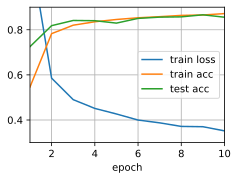

In [9]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(params, lr, batch_size))

In [10]:
d2l.evaluate_accuracy(net, test_iter)

0.8557

#### 4.6.5 Concise Implementation

Using Gluon, all we need to do is add a Dropout layer (also in the nn package) after each fully-connected layer, passing in the dropout probability as the only argument to its constructor. During training, the Dropout layer will randomly drop out outputs of the previous layer (or equivalently, the inputs to the subsequent layer) according to the specified dropout probability. When MXNet is not in training mode, the Dropout layer simply passes the data through during the testing phase.

In [11]:
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'),
        nn.Dropout(dropout1),
        nn.Dense(256, activation='relu'),
        nn.Dropout(dropout2),
        nn.Dense(10))
net.initialize(init.Normal(sigma = 0.01))

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

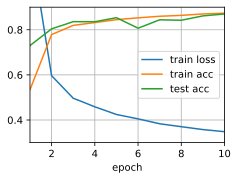

In [12]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)